## City for a pleasant life

### 1. A description of the problem 

I have a good friend.<br>
And I want to help him.
***
My friend is a famous artist.<br>
And now he is looking for a city to which he could go to work.<br>
Of course, first of all he is interested in art.<br>
As for all people of art, the environment, the atmosphere in which he will live, means a lot to him.
* * * * *
Suppose they have the opportunity to move to one of several cities. 
In one of the areas of these cities.
Let it be Toronto and his districts (or Florence, Stockholm or Minsk ...).

I want, using data analysis, to determine which district of which city will be 
the most pleasant for my friend's family.
* * * * *
His family consists of three people - himself, his wife and daughter.
And he wants each of them to get what he likes in the new city.
* * * * *
His wife is a very good cook. He knows the cuisine of different countries. But he wants to know even more.

Their daughter loves all the tasty things - juices, ice cream, fruit.

My friend is a subtle connoisseur of wine and coffee. But does not like beer.

#### 1.1. Audience of my project and why they would care about this  problem

The audience of my project is people who want to change their place of residence.<br>
Or just tourists who want to choose not just a place where you can live for several weeks.<br> 
For this, sites https://www.booking.com or https://www.airbnb.ru are enough.<br>
And the place where it can be done with the greatest pleasure.

Why will they take care of this problem?

Because it is new for them, interesting and necessary.<br>
And it costs almost nothing)

### 2. Discussion of the background

It is clear that the wife agrees to live in the district of city where there are many cafes and a variety of restaurants - Italian, Indian, Chinese, Japanese ...

Daughter - where there are many children's cafes, ice cream cafes, flower shops ...

My friend - where there are liquor stores, bars, but not pubs)

                         * * * * *
                         
Obviously, in order to be able to make a decision, the task must be formalized.

Let the number of places in the area, pleasant for the wife - W.
Number of places pleasant for a child - D.
Number of places pleasant for a friend - F.

We will also assume that the result of the choice of each family member affects to varying degrees. The coefficient for choosing a friend is f, wives — w, daughters — d. 
And f + c + d = 1.

It is also important to consider how many people live in the area. 
If there are a lot of them, this is not the best option.

Thus, the task is reduced to the fact that you need to find a DS district in one of the cities S, such that

         R (S, DS) = (F * f + W * w + D * d) / P                     (*)

where P is the population of the district, will be the greatest.

You can even more detail:

         R (S, DS1, ..., DSn) = (F * f + W * w + D * d) / P          (**)

### 3. A description of the data


Wikipedia (city's districts, population): https://en.wikipedia.org

Google Maps Geocoding API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/
 
Geographical coordinates for postal codes: http://cocl.us/Geospatial_data

Foursquare API: https://api.foursquare.com

### 4. How it will be used to solve the problem

1. From the pages of Wikipedia to obtain data on the administrative-territorial division of cities.
2. About the population of cities and their areas.
3. Associate the information found with the geographical coordinates of the areas.
4. Get, using the service Foursquare, information about places located in these areas.
5. Select those places that interest family members, and count their number.
6. Apply the formula (*) or (**) to the found information.
7. Choose the best result and recommend it to my friend.

8. Listen to his comments (or suggestions) and try to search for information in a new way. 

### 5. Methodology section

#### 5.1. Import libraryes

In [172]:
import pandas as pd
import pickle

In [173]:
import folium
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [174]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### 5.2. Download data on areas of the city of Toronto. 
The data were prepared earlier in the LAB: 
"Segmenting and Clustering Neighborhoods in Toronto"

In [175]:
df = pickle.load(open('df.pkl', 'rb'))
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### 5.3. Prepare 'data' - a new DataFrame to store data on venues in Toronto

In [176]:
data = {'Borough':[], 'Neighbourhood':[], 'Neighbourhood_Latitude':[],
        'Neighbourhood_Longitude':[], 'Venue':[], 'Venue_Latitude':[],
        'Venue_Longitude':[], 'Venue_Category':[]}
data = pd.DataFrame(data = data)
data

,Borough,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Category,Venue_Latitude,Venue_Longitude


#### 5.4. Obtain data using Foursquare API

In [278]:
CLIENT_ID = 'FPL1JVXDNWV3OMJKFGSSJQN2EEPCF5WKKBWNZQ0BLLUK2NZN' # your Foursquare ID
CLIENT_SECRET = 'FPL1JVXDNWV3OMJKFGSSJQN2EEPCF5WKKBWNZQ0BLLUK2NZN' # your Foursquare Secret
VERSION = '20190119' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FPL1JVXDNWV3OMJKFGSSJQN2EEPCF5WKKBWNZQ0BLLUK2NZN
CLIENT_SECRET:FPL1JVXDNWV3OMJKFGSSJQN2EEPCF5WKKBWNZQ0BLLUK2NZN


In [180]:
for iNeigh in df.index:

    neighbourhood_latitude = df.loc[iNeigh, 'Latitude'] # neighbourhood latitude value
    neighbourhood_longitude = df.loc[iNeigh, 'Longitude'] # neighbourhood longitude value
    neighbourhood_name = df.loc[iNeigh, 'Neighbourhood'] # neighbourhood name
    
    # type your answer here
    LIMIT = 1000 # limit of number of venues returned by Foursquare API

    radius = 1000 # define radius

    # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighbourhood_latitude, 
        neighbourhood_longitude, 
        radius, 
        LIMIT)
#    url # display URL
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    if nearby_venues.shape == (0,0):
        continue
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
    
    for iv in nearby_venues.index:
        data = data.append(
            {'Borough': df.loc[iNeigh, 'Borough'], 
             'Neighbourhood': df.loc[iNeigh, 'Neighbourhood'],
             'Neighbourhood_Latitude': df.loc[iNeigh, 'Latitude'],
             'Neighbourhood_Longitude': df.loc[iNeigh, 'Longitude'],
             'Venue': nearby_venues.loc[iv, 'name'],
             'Venue_Latitude': nearby_venues.loc[iv, 'lat'],
             'Venue_Longitude': nearby_venues.loc[iv, 'lng'],
             'Venue_Category': nearby_venues.loc[iv, 'categories']}, ignore_index=True)


16 venues were returned by Foursquare.
4 venues were returned by Foursquare.
24 venues were returned by Foursquare.
8 venues were returned by Foursquare.
30 venues were returned by Foursquare.
11 venues were returned by Foursquare.
23 venues were returned by Foursquare.
29 venues were returned by Foursquare.
13 venues were returned by Foursquare.
14 venues were returned by Foursquare.
46 venues were returned by Foursquare.
25 venues were returned by Foursquare.
47 venues were returned by Foursquare.
30 venues were returned by Foursquare.
30 venues were returned by Foursquare.
24 venues were returned by Foursquare.
21 venues were returned by Foursquare.
43 venues were returned by Foursquare.
14 venues were returned by Foursquare.
4 venues were returned by Foursquare.
30 venues were returned by Foursquare.
100 venues were returned by Foursquare.
16 venues were returned by Foursquare.
11 venues were returned by Foursquare.
29 venues were returned by Foursquare.
33 venues were returned by 

In [187]:
data.columns = ['Borough', 'Neighbourhood', 'Neighbourhood_Latitude',
        'Neighbourhood_Longitude', 'Venue', 'Venue_Category',
        'Venue_Latitude', 'Venue_Longitude']

In [188]:
data

,Borough,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Category,Venue_Latitude,Venue_Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Images Salon & Spa,Spa,43.802283,-79.198565
1,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
2,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Wendy's,Fast Food Restaurant,43.802008,-79.198080
3,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Harvey's,Fast Food Restaurant,43.800106,-79.198258
4,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Wendy's,Fast Food Restaurant,43.807448,-79.199056
5,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Tim Hortons,Coffee Shop,43.802000,-79.198169
6,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Staples Morningside,Paper / Office Supplies Store,43.800285,-79.196607
7,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Lee Valley,Hobby Shop,43.803161,-79.199681
8,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Tim Hortons / Esso,Coffee Shop,43.801660,-79.199133
9,Scarborough,"Rouge,Malvern",43.806686,-79.194353,MMA World Academy,Martial Arts Dojo,43.800259,-79.195227


In [189]:
data.shape

(4852, 8)

In [190]:
pickle.dump(data, open('0-102.pkl', 'wb'))

In [191]:
data = pickle.load(open('0-102.pkl', 'rb'))

#### 5.5. Get all Venue Category from data

In [192]:
data['Venue_Category'].unique()

array(['Spa', 'Caribbean Restaurant', 'Fast Food Restaurant',
       'Coffee Shop', 'Paper / Office Supplies Store', 'Hobby Shop',
       'Martial Arts Dojo', 'African Restaurant', 'Chinese Restaurant',
       'Greek Restaurant', 'Fruit & Vegetable Store', 'Gym',
       'Sandwich Place', 'Italian Restaurant', 'Burger Joint',
       'Breakfast Spot', 'Playground', 'Fried Chicken Joint',
       'Food & Drink Shop', 'Liquor Store', 'Pizza Place',
       'Smoothie Shop', 'Discount Store', 'Beer Store', 'Pharmacy',
       'Bank', 'Sports Bar', 'Supermarket', 'Plaza', 'Restaurant',
       'Grocery Store', 'Park', 'Indian Restaurant', 'Electronics Store',
       'Hakka Restaurant', 'Thai Restaurant', 'Music Store',
       'Athletics & Sports', 'Bakery', 'Wings Joint', 'Yoga Studio',
       'Lounge', 'Rental Car Location', 'Bus Line', 'Home Service',
       'Sporting Goods Shop', 'Convenience Store', 'Train Station',
       'Japanese Restaurant', 'Bowling Alley', 'Department Store',
       'Li

#### 5.6. We will create categories of venues that each family member likes - husband (F), wife (W), daughter (D)

In [193]:
my_categories = {'F': [], 'W': [], 'D': []}

In [194]:
my_categories['W'] = ['Spa',
 'Caribbean Restaurant',
 'Fast Food Restaurant',
 'Coffee Shop',
 'African Restaurant',
 'Chinese Restaurant',
 'Greek Restaurant',
 'Fruit & Vegetable Store',
 'Sandwich Place',
 'Italian Restaurant',
 'Burger Joint',
 'Breakfast Spot',
 'Fried Chicken Joint',
 'Food & Drink Shop',
 'Pizza Place',
 'Grocery Store',
 'Indian Restaurant',
 'Electronics Store',
 'Hakka Restaurant',
 'Thai Restaurant',
 'Bakery',
 'Japanese Restaurant',
 'Asian Restaurant',
 'Mexican Restaurant',
 'Cajun / Creole Restaurant',
 'Café',
 'Latin American Restaurant',
 'Vietnamese Restaurant',
 'Dessert Shop',
 'Korean Restaurant',
 'Fish Market',
 'Middle Eastern Restaurant',
 'Seafood Restaurant',
 'Flea Market',
 'Sri Lankan Restaurant',
 'Malay Restaurant',
 'Cantonese Restaurant',
 'Sushi Restaurant',
 'Mediterranean Restaurant',
 'Shanghai Restaurant',
 'American Restaurant',
 'Filipino Restaurant',
 'Bubble Tea Shop',
 'Taiwanese Restaurant',
 'Market',
 'Vegetarian / Vegan Restaurant',
 'Toy / Game Store',
 'Candy Store',
 'Tea Room',
 'Juice Bar',
 'Hot Dog Joint',
 'Ramen Restaurant',
 'Steakhouse',
 'Indonesian Restaurant',
 'Karaoke Bar',
 'Frozen Yogurt Shop',
 'French Restaurant',
 'Butcher',
 'Eastern European Restaurant',
 'Fish & Chips Shop',
 'Salad Place',
 'Cafeteria',
 "Women's Store",
 'Dim Sum Restaurant',
 'Jewelry Store',
 'Deli / Bodega',
 'Turkish Restaurant',
 'Falafel Restaurant',
 'Snack Place',
 'Portuguese Restaurant',
 'Gastropub',
 'Farmers Market',
 'Chocolate Shop',
 'Restaurant',
 'Afghan Restaurant',
 'Ethiopian Restaurant',
 'Donut Shop',
 'Gourmet Shop',
 'Health Food Store',
 'Tapas Restaurant',
 'Cuban Restaurant',
 'New American Restaurant',
 'Pakistani Restaurant',
 'Indian Chinese Restaurant',
 'Comfort Food Restaurant',
 'Buffet',
 'Garden',
 'Modern European Restaurant',
 'German Restaurant',
 'Gift Shop',
 'Pie Shop',
 'Farm',
 'Piano Bar',
 'Gay Bar',
 'Sake Bar',
 'Persian Restaurant',
 'Spanish Restaurant',
 'Cocktail Bar',
 'Bistro',
 'Belgian Restaurant',
 'Brazilian Restaurant']

In [195]:
 my_categories['D'] = ['Hobby Shop',
 'Gym',
 'Smoothie Shop',
 'Sports Bar',
 'Plaza',
 'Park',
 'Music Store',
 'Athletics & Sports',
 'Yoga Studio',
 'Bowling Alley',
 'General Entertainment',
 'Skating Rink',
 'College Stadium',
 'Gym Pool',
 'Gym / Fitness Center',
 'Hookah Bar',
 'Hong Kong Restaurant',
 'Hotpot Restaurant',
 'Cosmetics Shop',
 'Ice Cream Shop',
 'Clothing Store',
 'Theater',
 'Food Court',
 'Skate Park',
 'Hotel',
 'Arts & Crafts Store',
 'Mobile Phone Shop',
 'Dance Studio',
 'Bridal Shop',
 'Video Store',
 'Rock Climbing Spot',
 'Brewery',
 'Bagel Shop',
 'Cupcake Shop',
 'Nail Salon',
 'Performing Arts Venue',
 'Health & Beauty Service',
 'Cheese Shop',
 'Flower Shop',
 'Wine Shop',
 'Concert Hall',
 'Coworking Space',
 'Rock Club',
 'Boutique',
 'Pide Place',
 'College Quad',
 'College Gym',
 'Wine Bar',
 'Gaming Cafe',
 'Nightclub',
 'Animal Shelter',
 'Food Truck',
 'Museum',
 'University',
 'Aquarium',
 'Baseball Stadium',
 'Hardware Store',
 'Baby Store',
 'Music School',
 'School',
 'Doner Restaurant',
 'Street Art',
 'Other Repair Shop',
 'Stadium',
 'Beach Bar',
 'Zoo',
 'Pilates Studio',
 'River',
 'College Theater',
 'Social Club']

In [196]:
my_categories['F'] = ['Liquor Store',
  'Discount Store',
  'Sporting Goods Shop',
  'Convenience Store',
  'Soccer Field',
  'Pet Store',
  'Badminton Court',
  'Smoke Shop',
  'Bar',
  'Pool Hall',
  'Shopping Mall',
  'Motorcycle Shop',
  'Print Shop',
  'Golf Course',
  'BBQ Joint',
  'Tennis Court',
  'Hockey Arena',
  "Men's Store",
  'Jazz Club',
  'Indie Theater',
  'Art Gallery',
  'Art Museum',
  'Design Studio',
  'Whisky Bar']

#### 5.7. For each venue we add its category (column 'Cat') to  'data' - F, B or D

In [197]:
for i in data.index:
    data.loc[i,'Cat'] = 'F' if data.loc[i,'Venue_Category'] in my_categories['F'] else 'W' if data.loc[i,'Venue_Category'] in my_categories['W'] else 'D'

##### 5.8. Find the number of venues that each family member likes in each of the city districts

In [198]:
db = data[['Borough', 'Neighbourhood', 'Cat', 'Venue']].groupby(['Borough', 'Neighbourhood', 'Cat'], sort=(True, True, False)).count()
db

Venue
Borough          Neighbourhood                                      Cat       
Central Toronto  Davisville                                         D       27
                                                                    F        2
                                                                    W       71
                 Davisville North                                   D       25
                                                                    F        5
                                                                    W       70
                 Deer Park,Forest Hill SE,Rathnelly,South Hill,S... D       26
                                                                    F        3
                                                                    W       46
                 Forest Hill North,Forest Hill West                 D       18
                                                                    F        1
                                                                    W       27
                 Lawrence Park                                      D        6
                                                                    W        3
                 Moore Park,Summerhill East                         D       24
                                                                    F        1
                                                                    W       37
                 North Toronto West                                 D       12
                                                                    F        4
                                                                    W       25
                 Roselawn                                           D        7
                                                                    F        1
                                                                    W       17
                 The Annex,North Midtown,Yorkville                  D       36
                                                                    F        4
                                                                    W       60
Downtown Toronto Adelaide,King,Richmond                             D       43
                                                                    F        7
                                                                    W       50
                 Berczy Park                                        D       41
...                                                                        ...
West Toronto     Dovercourt Village,Dufferin                        D       26
                                                                    F        9
                                                                    W       30
                 High Park,The Junction South                       D       30
                                                                    F       14
                                                                    W       56
                 Little Portugal,Trinity                            D       29
                                                                    F       13
                                                                    W       58
                 Parkdale,Roncesvalles                              D       33
                                                                    F       11
                                                                    W       56
                 Runnymede,Swansea                                  D       21
                                                                    F        2
                                                                    W       51
York             Caledonia-Fairbanks                                D       11
                                                                    F        2
                                                                    W       12
                 Del Ray,Keelesdale,Mount De

#### 5.9. Add the values found to "df" common data frame

In [199]:
df['D'] = 0
df['F'] = 0
df['W'] = 0

for ind in db.index:
    df_ind = df[(df.Borough == ind[0]) & (df.Neighbourhood == ind[1])].index[0]
    df.at[df_ind,ind[2]]  = int(db.loc[ind][0])
df


,Postcode,Borough,Neighbourhood,Latitude,Longitude,D,F,W
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,4,0,12
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,0,3
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,7,2,15
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2,0,6
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,12,1,17
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,2,1,8
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,5,4,14
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,16,2,11
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,6,0,7
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,9,1,4


### 6. Results section

#### 6.1. We will find the most pleasant for living areas in Toronto with different family priority schemes.
(who is the most important family member - who is less important - who is the least) and various factors (h, w, d)

In [256]:
gdata = {'f >> w > d': [], 'f < w << d': [], 'w >> f > d': [], 'f = w = d': []}
gnsdata = {'f >> w > d': [], 'f < w << d': [], 'w >> f > d': [], 'f = w = d': []}
cdata = pd.DataFrame(columns=['Latitude', 'Longitude', 'Cluster', 'Borough', 'Neighbourhood'])

#### 6.2. Family priority scheme (f >> w > d) 

In [257]:
scheme, f, w, d = 'f >> w > d', 0.7, 0.2, 0.1

df['Like'] = f*df['F'] + w*df['W'] + d*df['D']
td = df.sort_values(by = 'Like', ascending=False)
gdata[scheme] = td['Like'].values.tolist()
gnsdata[scheme] = df['Like'].values.tolist()
for i in range(5):
    cdata = cdata.append({'Cluster':0, 
                          'Latitude': td.loc[i,'Latitude'], 'Longitude': td.loc[i,'Longitude'], 
                          'Borough': td.loc[i,'Borough'], 'Neighbourhood': td.loc[i,'Neighbourhood']},
           ignore_index=True)
td.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,D,F,W,Like
82,M6P,West Toronto,"High Park,The Junction South",43.661608,-79.464763,30,14,56,24.0
77,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750,29,13,58,23.6
83,M6R,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325,33,11,56,22.2
67,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,31,9,60,21.4
40,M4J,East York,East Toronto,43.685347,-79.338106,25,8,66,21.3


6.3. Family priority scheme (f < w << d)

In [260]:
scheme, f, w, d = 'f < w << d', 0.1, 0.2, 0.7
df['Like'] = f*df['F'] + w*df['W'] + d*df['D']
gdata[scheme] = df.sort_values(by = 'Like', ascending=False)['Like'].values.tolist()
gnsdata[scheme] = df['Like'].values.tolist()
for i in range(5):
    cdata = cdata.append({'Cluster':1, 
                          'Latitude': td.loc[i,'Latitude'], 'Longitude': td.loc[i,'Longitude'], 
                          'Borough': td.loc[i,'Borough'], 'Neighbourhood': td.loc[i,'Neighbourhood']},
           ignore_index=True)
df.sort_values(by = 'Like', ascending=False).head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,D,F,W,Like
59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,53,5,42,46.0
60,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,46,4,50,42.6
78,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,45,8,47,41.7
58,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,43,7,50,40.8
70,M5X,Downtown Toronto,"First Canadian Place,Underground city",43.648429,-79.382280,41,7,52,39.8


6.4. Family priority scheme (w >> f > d)

In [261]:
scheme, f, w, d = 'w >> f > d', 0.2, 0.7, 0.1
df['Like'] = f*df['F'] + w*df['W'] + d*df['D']
gdata[scheme] = df.sort_values(by = 'Like', ascending=False)['Like'].values.tolist()
gnsdata[scheme] = df['Like'].values.tolist()
for i in range(5):
    cdata = cdata.append({'Cluster':2, 
                          'Latitude': td.loc[i,'Latitude'], 'Longitude': td.loc[i,'Longitude'], 
                          'Borough': td.loc[i,'Borough'], 'Neighbourhood': td.loc[i,'Neighbourhood']},
           ignore_index=True)
df.sort_values(by = 'Like', ascending=False).head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,D,F,W,Like
22,M2N,North York,Willowdale South,43.770120,-79.408493,21,4,75,55.4
47,M4S,Central Toronto,Davisville,43.704324,-79.388790,27,2,71,52.8
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,25,5,70,52.5
75,M6G,Downtown Toronto,Christie,43.669542,-79.422564,26,5,69,51.9
40,M4J,East York,East Toronto,43.685347,-79.338106,25,8,66,50.3


##### 6.5. Family priority scheme (f = w = d)

In [262]:
scheme, f, w, d = 'f = w = d', 1/3, 1/3, 1/3
df['Like'] = f*df['F'] + w*df['W'] + d*df['D']
gdata[scheme] = df.sort_values(by = 'Like', ascending=False)['Like'].values.tolist()
gnsdata[scheme] = df['Like'].values.tolist()
for i in range(5):
    cdata = cdata.append({'Cluster':3, 
                          'Latitude': td.loc[i,'Latitude'], 'Longitude': td.loc[i,'Longitude'], 
                          'Borough': td.loc[i,'Borough'], 'Neighbourhood': td.loc[i,'Neighbourhood']},
           ignore_index=True)
df.sort_values(by = 'Like', ascending=False).head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,D,F,W,Like
75,M6G,Downtown Toronto,Christie,43.669542,-79.422564,26,5,69,33.333333
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,29,5,66,33.333333
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,41,7,52,33.333333
83,M6R,West Toronto,"Parkdale,Roncesvalles",43.648960,-79.456325,33,11,56,33.333333
43,M4M,East Toronto,Studio District,43.659526,-79.340923,34,9,57,33.333333


#### 6.6. Imagine the data in graphical form

On __Oy__ axis - calculated level of pleasant living

The data is sorted by value "level of pleasant living."
Therefore, the values on axis __Ox__ - can not be determined.

Text(0.5, 0, "Different 'Borough - Neighbourhood' of Toronto")

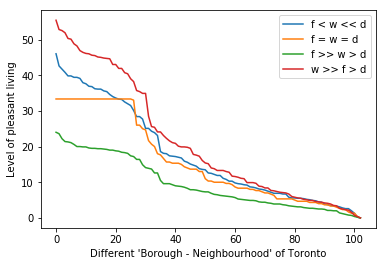

In [214]:
%matplotlib inline

gd = pd.DataFrame(data = gdata)
ax = gd.plot()
ax.set_ylabel("Level of pleasant living")
ax.set_xlabel("Different 'Borough - Neighbourhood' of Toronto")

#### 6.7. Imagine the data in graphical form

On __Oy__ axis - calculated level of pleasant living

The data is not sorted by value "level of pleasant living."
Therefore, on axis __Ox__ - number of __'Borough - Neighbourhood'__.

Text(0.5, 0, "Number 'Borough - Neighbourhood' from df-DataFrame")

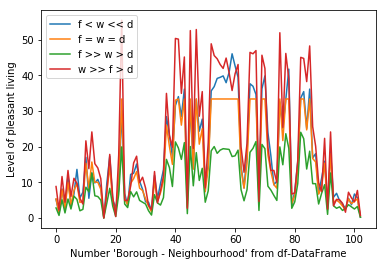

In [215]:
gd = pd.DataFrame(data = gnsdata)
ax = gd.plot()
ax.set_ylabel("Level of pleasant living")
ax.set_xlabel("Number 'Borough - Neighbourhood' from df-DataFrame")

#### 6.8. Imagine the Top-5 data in graphical form for each scheme

On __Oy__ axis - calculated level of pleasant living

The data is sorted by value "level of pleasant living."
Therefore, the values on axis __Ox__ - can not be determined.

Text(0.5, 0, "Top-5 'Borough - Neighbourhood' from df-DataFrame")

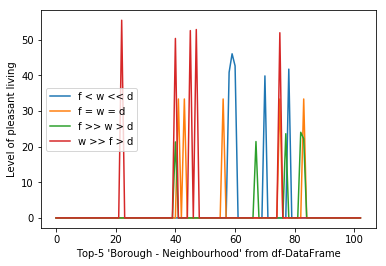

In [227]:
gd = pd.DataFrame(data = gnsdata)
for i in range(len(gd.columns)):
    gd.sort_values(by = gd.columns[i], ascending=False, inplace = True)
    gd.iloc[5:,i] = 0
    gd.sort_index(ascending=True, inplace=True)
ax = gd.plot()
ax.set_ylabel("Level of pleasant living")
ax.set_xlabel("Top-5 'Borough - Neighbourhood' from df-DataFrame")

#### 6.9 Create map

In [275]:
# create map
latitude, longitude = 43.650943, -79.554724
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
kclusters = 4
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cdata['Latitude'], cdata['Longitude'], cdata['Borough'] +"-"+ cdata['Neighbourhood'], cdata['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7. Discussion section

7.1. As can be seen from graph 6.6, the largest number of places to stay, from which all family members can enjoy, is achieved in the case when the __main person in the family is a wife__.

The __worst case__ is that - the main person in the family is __the husband__. In this case, finding a place becomes very difficult.

7.2. As can be seen from graph 6.7, the same area has a completely different level of attractiveness for life from the position of different family members.

Moreover, the requirements of the husband are met the worst in almost all areas.

7.3. As can be seen from graph 6.8, the areas best suited for living from the point of view of various family members do not practically intersect.

Of the 16 districts selected in four schemes, only 4 identical ones were found.

### 8. Conclusion section

Data analysis is a great tool.

It allows you to make interesting discoveries and find unexpected results.